In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, RFE, f_classif
from sklearn.model_selection import train_test_split,  GridSearchCV, KFold
from sklearn.ensemble import   RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [3]:
#Importing the data frame
premier_league = pd.read_csv('Premier_League.csv')

In [5]:
#Removing variable
premier_league = premier_league.drop(columns=['Div','FTHG','FTAG','HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
       'HY', 'AY', 'HR', 'AR','Attendance','HomeTeamPoints', 'AwayTeamPoints'],axis=1)



In [6]:
#encode all variables that are numerical 
#make all variables int or float
encoder = LabelEncoder()
premier_league['FTR']=encoder.fit_transform(premier_league['FTR'])
premier_league['HomeTeam']=encoder.fit_transform(premier_league['HomeTeam'])
premier_league['AwayTeam']=encoder.fit_transform(premier_league['AwayTeam'])

#remove / from date
premier_league['Date'] = premier_league['Date'].str.replace('/', '')
# Extract the first two digits of the year for 'ddmmyyyy' format
premier_league['Date'] = premier_league['Date'].apply(lambda x: x[:-4] + x[-2:] if len(x) == 8 else x)
# date to float 
premier_league['Date'] = premier_league['Date'].astype(int)

#remove / from season
premier_league['Season'] = premier_league['Season'].str.replace('/','')
#extract the end 2 values of each year
premier_league['Season'] = premier_league['Season'].apply(lambda x: x[2] + x[3] + x[6] + x[7])
#convert to integer 
premier_league['Season'] = premier_league['Season'].astype(int)

premier_league['PreCovid'] = premier_league['PreCovid'].astype(int)

In [7]:
#Check the data types
premier_league.dtypes

Season             int32
Date               int32
HomeTeam           int32
AwayTeam           int32
FTR                int32
HAGSFT           float64
AAGSFT           float64
HAGSHT           float64
AAGSHT           float64
HAGCFT           float64
AAGCFT           float64
HAR              float64
AAR              float64
HAY              float64
AAY              float64
HAF              float64
AAF              float64
HAC              float64
AAC              float64
HAS              float64
AAS              float64
HAST             float64
AAST             float64
HAWH             float64
HALH             float64
HADH             float64
AAWA             float64
AALA             float64
AADA             float64
PreCovid           int32
OverallHA        float64
SeasonalHA       float64
HAPreCovid       float64
HADuringCovid    float64
dtype: object

In [8]:
#Drop the 20/21 season
premier_league = premier_league.iloc[0:4180]


In [9]:
#Split data into X and y
X = premier_league.drop('FTR',axis=1)
y = premier_league['FTR']

In [10]:
#Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=92, shuffle =False)

In [11]:
#Scale variables 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Correlation

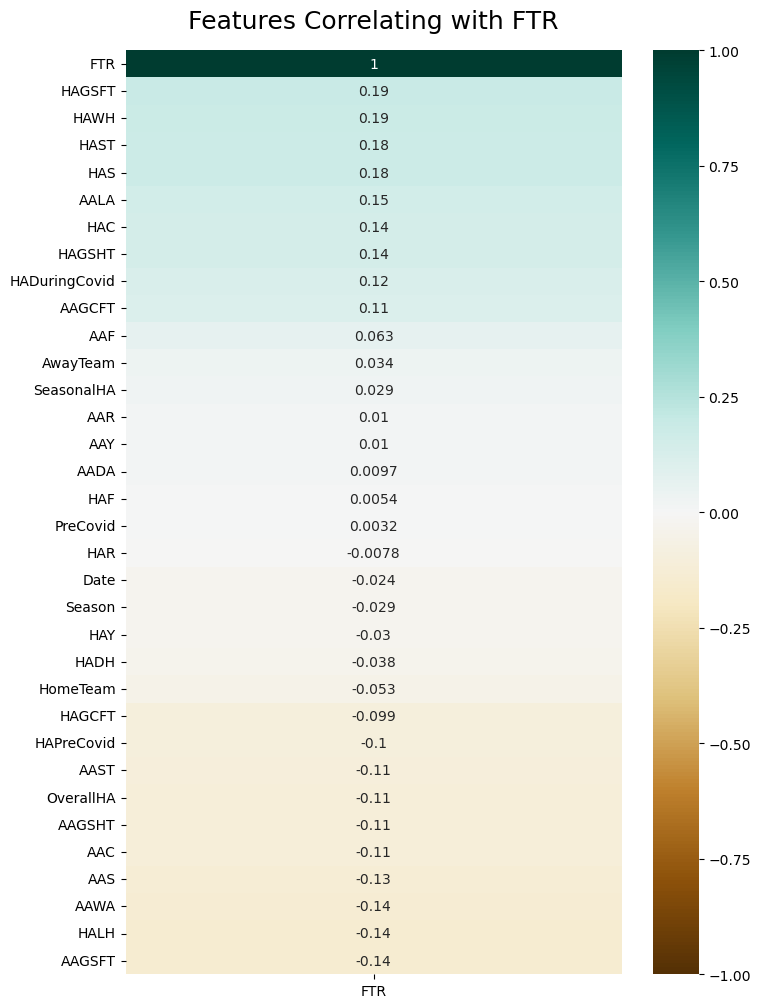

In [12]:
#Correlation with FTR 
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(premier_league.corr()[['FTR']].sort_values(by='FTR', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with FTR', fontdict={'fontsize':18}, pad=16);

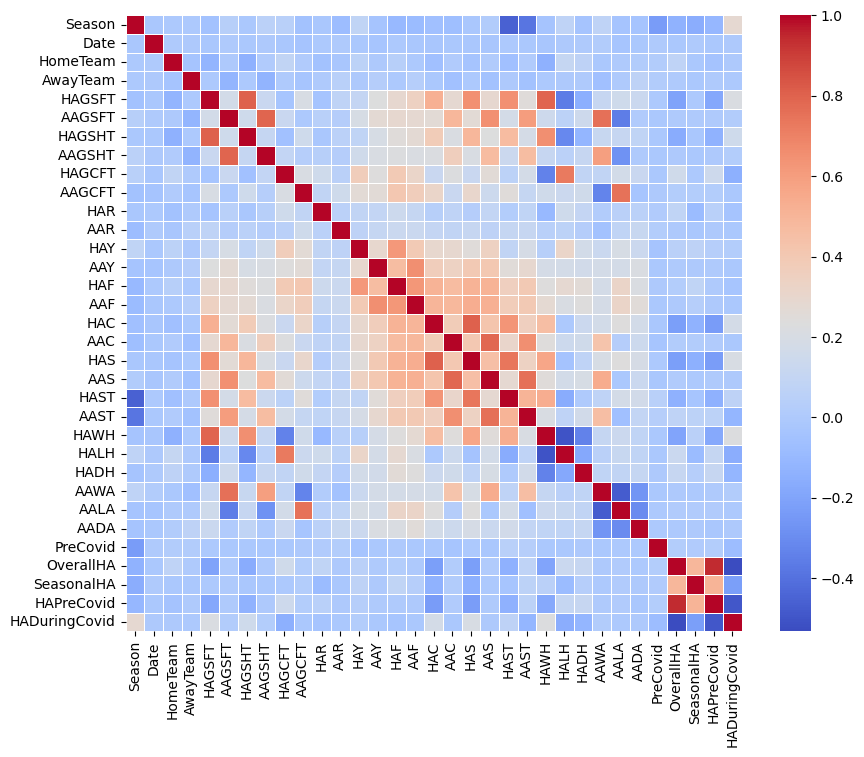

In [13]:
#Correlation heat map
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=.5, square=True,
            xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

plt.show()

In [14]:

# Find pairs of variables with correlation above 0.75
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            correlation_coefficient = correlation_matrix.iloc[i, j]
            high_corr_pairs.append((colname_i, colname_j, correlation_coefficient))

# Print the pairs of variables and their correlation coefficients above 0.75
print("Pairs of variables with correlation above 0.75:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

Pairs of variables with correlation above 0.75:
HAGSHT and HAGSFT: 0.80
AAGSHT and AAGSFT: 0.79
HAS and HAC: 0.80
AAS and AAC: 0.79
AAST and AAS: 0.76
HAWH and HAGSFT: 0.79
AAWA and AAGSFT: 0.76
AALA and AAGCFT: 0.75
HAPreCovid and OverallHA: 0.95


In [15]:
#features with high correlation are removed 
premier_league = premier_league.drop(columns = ['HAGSFT','AAGSFT','AAS','HAC','HAPreCovid'], axis=0)


In [16]:
#Recreating test and train with the removed variables
X=premier_league.drop('FTR',axis=1)
y=premier_league['FTR']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=92, shuffle =False)
#Scale variables 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Filter Method

In [17]:

# Use SelectKBest with ANOVA F-statistic to select the top k features

selector = SelectKBest(f_classif, k=5) #k=5 is the number of features to select
X_train_selected = selector.fit_transform(X, y)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Display the selected features
selected_features = X.columns[selected_feature_indices]
print(f"Top 5 Selected Features:")
print(selected_features)

Top 5 Selected Features:
Index(['HAGSHT', 'HAS', 'HAST', 'HAWH', 'AALA'], dtype='object')


# LASSO

In [18]:


# Initialise the LassoCV model with a range of alpha values
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]  
lasso_cv_model = LassoCV(alphas=alphas, cv=5)  # 5-fold cross-validation

# Train the LassoCV model
lasso_cv_model.fit(X_train, y_train)

# Find the optimal alpha
optimal_alpha = lasso_cv_model.alpha_
print(f"Optimal alpha: {optimal_alpha}")

# Make predictions
y_pred = lasso_cv_model.predict(X_test)

# Evaluate the model
print("Lasso Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred.round()))
print("Classification Report:\n", classification_report(y_test, y_pred.round()))

Optimal alpha: 1e-05
Lasso Regression Results:
Accuracy: 0.29347826086956524
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.23      0.95      0.37        20
           2       0.89      0.19      0.31        43

    accuracy                           0.29        92
   macro avg       0.37      0.38      0.23        92
weighted avg       0.47      0.29      0.22        92



In [19]:
# Initialise the Lasso model with the optimal alpha
lasso_model = Lasso(alpha=optimal_alpha)

# Train the Lasso model
lasso_model.fit(X_train, y_train)

# Get the coefficients and corresponding feature names
coefficients = lasso_model.coef_
feature_names = X.columns  

# Create a dictionary mapping feature names to their absolute coefficients
feature_coefficients = dict(zip(feature_names, abs(coefficients)))

# Sort the features based on their absolute coefficients in descending order
sorted_features = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)

# Select the top 5 features
top_5_features = [feature for feature, _ in sorted_features[:5]]

print("Top 5 Features selected by Lasso:")
print(top_5_features)

Top 5 Features selected by Lasso:
['AALA', 'AAWA', 'AADA', 'HALH', 'HAST']


# RFE

Selected Features: Index(['Date', 'AAC', 'HAS', 'AAST', 'SeasonalHA'], dtype='object')


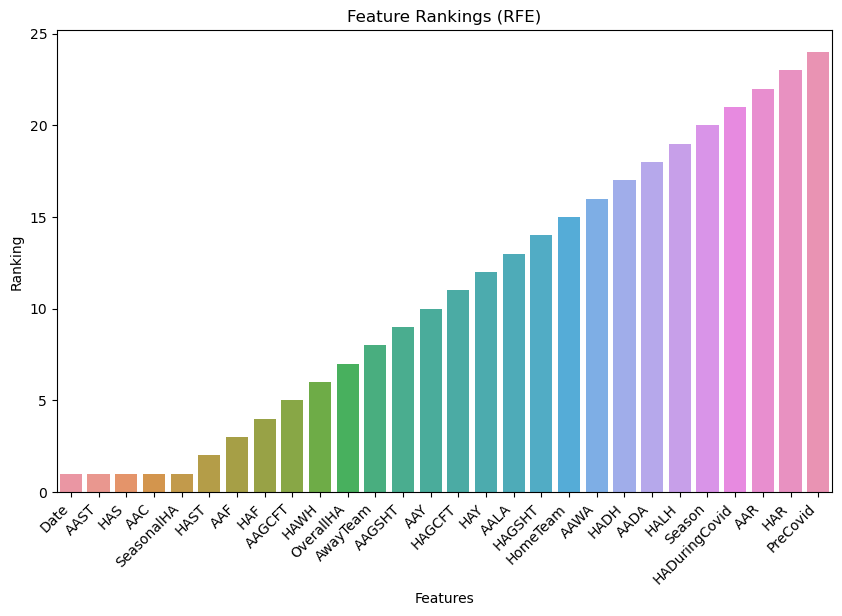

In [20]:

#Random Forest

# Initialize the model for RFE
model_rfe = RandomForestClassifier()

# Choose the number of features to select
num_features_to_select = 5

# Perform RFE
rfe = RFE(model_rfe, n_features_to_select=num_features_to_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Display selected features
X_columns = X.columns 

selected_features = X_columns[rfe.support_]
print("Selected Features:", selected_features)

# Plot feature rankings
feature_ranking = pd.Series(rfe.ranking_, index=X_columns)
feature_ranking_sorted = feature_ranking.sort_values(ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_ranking_sorted.index, y=feature_ranking_sorted.values)
plt.title("Feature Rankings (RFE)")
plt.xlabel("Features")
plt.ylabel("Ranking")
plt.xticks(rotation=45, ha="right")
plt.show()


# Classification

In [21]:
#Implementing the feature analysis

X=premier_league.drop('FTR', axis=1)
y= premier_league['FTR']
X = X[['HAS', 'AALA','HAST','SeasonalHA','AAWA']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=92, shuffle =False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Logistic Regression

In [22]:
log = LogisticRegression(max_iter=100000)

model_log = log.fit(X_train, y_train)

pred_log = model_log.predict(X_test)

accuray = accuracy_score(y_test, pred_log)
precision = precision_score(y_test, pred_log, average='weighted')
recall = recall_score(y_test, pred_log, average='weighted')
f1 = f1_score(y_test, pred_log, average='weighted')

print("The classification report of Logistic Regression classification: \n",classification_report(y_test, pred_log))


print("From the class report we can see that the classification has precision of {}%, with a recall of {}%, an f1-score of {}.".format(round(precision*100,2), round(recall*100, 2), f1))
print("The accuracy of the model is {}%".format(round(accuray*100,2)))

The classification report of Logistic Regression classification: 
               precision    recall  f1-score   support

           0       0.43      0.21      0.28        29
           1       0.00      0.00      0.00        20
           2       0.47      0.86      0.61        43

    accuracy                           0.47        92
   macro avg       0.30      0.36      0.30        92
weighted avg       0.36      0.47      0.37        92

From the class report we can see that the classification has precision of 35.68%, with a recall of 46.74%, an f1-score of 0.37381025996707584.
The accuracy of the model is 46.74%


## Decision Tree

In [23]:
# Set a seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
dt = DecisionTreeClassifier()

model_dt = dt.fit(X_train,y_train)

pred_dt = model_dt.predict(X_test)

accuray = accuracy_score(y_test, pred_dt)
precision = precision_score(y_test, pred_dt, average='weighted')
recall = recall_score(y_test, pred_dt, average='weighted')
f1 = f1_score(y_test, pred_dt, average='weighted')

print("The classification report of Decision Tree classification: \n",classification_report(y_test, pred_dt))


print("From the class report we can see that the classification has precision of {}%, with a recall of {}%, an f1-score of {}.".format(round(precision*100,2), round(recall*100, 2), f1))
print("The accuracy of the model is {}%".format(round(accuray*100,2)))

The classification report of Decision Tree classification: 
               precision    recall  f1-score   support

           0       0.36      0.31      0.33        29
           1       0.19      0.20      0.20        20
           2       0.50      0.53      0.52        43

    accuracy                           0.39        92
   macro avg       0.35      0.35      0.35        92
weighted avg       0.39      0.39      0.39        92

From the class report we can see that the classification has precision of 38.86%, with a recall of 39.13%, an f1-score of 0.38906331295848373.
The accuracy of the model is 39.13%


## Naive Bayes

In [24]:
nb = GaussianNB()

model_nb = nb.fit(X_train,y_train)

pred_nb = model_nb.predict(X_test)

accuray = accuracy_score(y_test, pred_nb)
precision = precision_score(y_test, pred_nb, average='weighted')
recall = recall_score(y_test, pred_nb, average='weighted')
f1 = f1_score(y_test, pred_nb, average='weighted')

print("The classification report of Naive Bayes classification: \n",classification_report(y_test, pred_nb))


print("From the class report we can see that the classification has precision of {}%, with a recall of {}%, an f1-score of {}.".format(round(precision*100,2), round(recall*100, 2), f1))
print("The accuracy of the model is {}%".format(round(accuray*100,2)))

The classification report of Naive Bayes classification: 
               precision    recall  f1-score   support

           0       0.52      0.52      0.52        29
           1       0.00      0.00      0.00        20
           2       0.54      0.79      0.64        43

    accuracy                           0.53        92
   macro avg       0.35      0.44      0.39        92
weighted avg       0.42      0.53      0.46        92

From the class report we can see that the classification has precision of 41.53%, with a recall of 53.26%, an f1-score of 0.46287940935192784.
The accuracy of the model is 53.26%


## SVM

In [25]:
svm = SVC()

model_svc = svm.fit(X_train,y_train)

pred_svc = model_svc.predict(X_test)

accuray = accuracy_score(y_test, pred_svc)
precision = precision_score(y_test, pred_svc, average='weighted')
recall = recall_score(y_test, pred_svc, average='weighted')
f1 = f1_score(y_test, pred_svc, average='weighted')

print("The classification report of Support Vector Machine classification: \n",classification_report(y_test, pred_svc))


print("From the class report we can see that the classification has precision of {}%, with a recall of {}%, an f1-score of {}.".format(round(precision*100,2), round(recall*100, 2), f1))
print("The accuracy of the model is {}%".format(round(accuray*100,2)))

The classification report of Support Vector Machine classification: 
               precision    recall  f1-score   support

           0       0.43      0.41      0.42        29
           1       0.00      0.00      0.00        20
           2       0.55      0.81      0.65        43

    accuracy                           0.51        92
   macro avg       0.33      0.41      0.36        92
weighted avg       0.39      0.51      0.44        92

From the class report we can see that the classification has precision of 39.07%, with a recall of 51.09%, an f1-score of 0.43849312431831305.
The accuracy of the model is 51.09%


## Random Forest

In [26]:
# Set a seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

rf = RandomForestClassifier(n_estimators=100, random_state=seed_value)

model_rf = rf.fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)

accuray = accuracy_score(y_test, pred_rf)
precision = precision_score(y_test, pred_rf, average='weighted')
recall = recall_score(y_test, pred_rf, average='weighted')
f1 = f1_score(y_test, pred_rf, average='weighted')

print("The classification report of Random Forest classification: \n",classification_report(y_test, pred_rf))


print("From the class report we can see that the classification has precision of {}%, with a recall of {}%, an f1-score of {}.".format(round(precision*100,2), round(recall*100, 2), f1))
print("The accuracy of the model is {}%".format(round(accuray*100,2)))

The classification report of Random Forest classification: 
               precision    recall  f1-score   support

           0       0.52      0.38      0.44        29
           1       0.13      0.10      0.11        20
           2       0.55      0.72      0.63        43

    accuracy                           0.48        92
   macro avg       0.40      0.40      0.39        92
weighted avg       0.45      0.48      0.46        92

From the class report we can see that the classification has precision of 45.28%, with a recall of 47.83%, an f1-score of 0.4562500784239915.
The accuracy of the model is 47.83%


# Final Tables

In [27]:
#Reload the data frame
premier_league = pd.read_csv('Premier_League.csv')
#Isolate the 19/20 season
pl_19_20 = premier_league[premier_league['Season']=='2019/2020']


In [28]:
# Create a data frame to store total points for each team within each season
total_points_home = pl_19_20.groupby(['Season', 'HomeTeam'])['HomeTeamPoints'].max().reset_index()
total_points_away = pl_19_20.groupby(['Season', 'AwayTeam'])['AwayTeamPoints'].max().reset_index()

# Merge the data frame to combine home and away points
actual_points = pd.merge(total_points_home, total_points_away, how='outer', left_on=['Season', 'HomeTeam'], right_on=['Season', 'AwayTeam'], suffixes=('_Home', '_Away'))


# Calculate total points for each team by combining home and away points
actual_points['ActualTotalPoints'] = actual_points['HomeTeamPoints'] + actual_points['AwayTeamPoints']

# Swap the positions of sheffield united and burnely 
actual_points.loc[[4, 14]] = actual_points.loc[[14, 4]].to_numpy()

# Sort the data frame by Season and TotalPoints columns
actual_points = actual_points.sort_values(by=['ActualTotalPoints'], ascending=False)

#Selecting the columns and reordering them
actual_points = actual_points[['Season', 'HomeTeam', 'HomeTeamPoints', 'AwayTeamPoints', 'ActualTotalPoints']]
#Adjust the placement by total points
actual_points['ActualPlacement'] = actual_points['ActualTotalPoints'].rank(ascending=False, method='first').astype(int)


In [29]:
#displaying the actual final table 
actual_points_1 = actual_points.drop(columns=['Season','ActualPlacement'], axis=1)
actual_points_1 = actual_points_1.rename(columns={'HomeTeam':'Team', 'HomeTeamPoints':'Home Points', 'AwayTeamPoints':'Away Points', 'ActualTotalPoints':'Total Points'})

print(actual_points_1)

                Team  Home Points  Away Points  Total Points
9          Liverpool           55           44            99
10          Man City           47           34            81
11        Man United           37           29            66
5            Chelsea           36           30            66
8          Leicester           37           25            62
16         Tottenham           39           20            59
19            Wolves           31           28            59
0            Arsenal           36           20            56
4   Sheffield United           33           21            54
14           Burnley           28           26            54
15       Southampton           21           31            52
7            Everton           31           18            49
12         Newcastle           26           18            44
6     Crystal Palace           23           20            43
3           Brighton           22           19            41
18          West Ham    

In [30]:
#spliting the season by the test and train data 
pl_19_20_train = pl_19_20[pl_19_20['PreCovid']==True]
pl_19_20_test = pl_19_20[pl_19_20['PreCovid']==False]

In [31]:
#total_points_train 

# Create a data frame to store total points for each team within each season
total_points_home = pl_19_20_train.groupby(['Season', 'HomeTeam'])['HomeTeamPoints'].max().reset_index()
total_points_away = pl_19_20_train.groupby(['Season', 'AwayTeam'])['AwayTeamPoints'].max().reset_index()

# Merge the data frame to combine home and away points
actual_points_train = pd.merge(total_points_home, total_points_away, how='outer', left_on=['Season', 'HomeTeam'], right_on=['Season', 'AwayTeam'], suffixes=('_Home', '_Away'))


# Calculate total points for each team by combining home and away points
actual_points_train['ActualTotalPoints'] = actual_points_train['HomeTeamPoints'] + actual_points_train['AwayTeamPoints']

#Select specific columns
actual_points_train = actual_points_train[['Season', 'HomeTeam', 'HomeTeamPoints', 'AwayTeamPoints', 'ActualTotalPoints']]
# Display the resulting data frame with the specified columns
actual_points_train = actual_points_train[['Season','HomeTeam','ActualTotalPoints']]

In [32]:
def calculate_points(pl_19_20_test, pred_values):
    #Add predicted points column 
    pl_19_20_test['Predicted'] = pred_values
    
    
    #Ititialise home and away points to zero
    pl_19_20_test['PredictedHomePoints'] = 0
    pl_19_20_test['PredictedAwayPoints'] = 0
    
    
    #Function to update points based on the predicted outcomes
    def update_points(row):
        if row['Predicted'] == 2:
            row['PredictedHomePoints'] += 3
        elif row['Predicted'] == 1:
            row['PredictedHomePoints'] += 1
            row['PredictedAwayPoints'] += 1
        elif row['Predicted'] == 0:
            row['PredictedAwayPoints'] += 3
        return row
    
     #Apply the function to each row
    pl_19_20_test = pl_19_20_test.apply(update_points, axis=1)
    
    #Calculate cumilative points for home and away
    pl_19_20_test['PredictedHomePoints'] = pl_19_20_test.groupby(['HomeTeam'])['PredictedHomePoints'].cumsum()
    pl_19_20_test['PredictedAwayPoints'] = pl_19_20_test.groupby(['AwayTeam'])['PredictedAwayPoints'].cumsum()
    
    
    #Calculate total points for home and away teams 
    total_points_home = pl_19_20_test.groupby(['Season', 'HomeTeam'])['PredictedHomePoints'].max().reset_index()
    total_points_away = pl_19_20_test.groupby(['Season', 'AwayTeam'])['PredictedAwayPoints'].max().reset_index()
    
    
    #Merge total points for home and away and actual points
    predicted_points = pd.merge(total_points_home, total_points_away, how='outer',
                                left_on=['Season', 'HomeTeam'], right_on=['Season', 'AwayTeam'],
                                suffixes=('_Home', '_Away'))
    predicted_points = pd.merge(predicted_points, actual_points_train, how='outer', left_on=['Season','HomeTeam'],
                                right_on=['Season','HomeTeam'])
    
    #Calculate total points
    predicted_points['PredictedTotalPoints'] = predicted_points['PredictedHomePoints'] + predicted_points['PredictedAwayPoints']
    
    #Add acutal and predicted points 
    predicted_points['PredictedTotalPoints'] = predicted_points['PredictedTotalPoints'] + predicted_points['ActualTotalPoints']
    
    #Sort predicted points by total points in descending order
    predicted_points = predicted_points.sort_values(by=['PredictedTotalPoints'], ascending=False)
    
    #Select and reorder the columns for predicted points
    predicted_points = predicted_points[['Season', 'HomeTeam', 'PredictedHomePoints', 'PredictedAwayPoints', 'PredictedTotalPoints']]
    
    #Merge acutal points and prediucted points and sort the table by total point in descending order
    total_points= pd.merge(actual_points, predicted_points,
                                     how='outer', left_on=['Season', 'HomeTeam'], right_on=['Season', 'HomeTeam'])
    total_points = total_points.sort_values(by=['PredictedTotalPoints'], ascending=False)
    
    #Reset the index
    total_points = total_points.reset_index(drop=True)
    
    #dropping columns
    total_points = total_points.drop(columns=['HomeTeamPoints','AwayTeamPoints','ActualTotalPoints','Season'],axis=1)
    
    #renaming columns 
    total_points = total_points.rename(columns={'HomeTeam':'Team','ActualPlacement':'Actual Placement'})
    
    
    
    return total_points


In [37]:
#Final tables for random forest and decision tree 
final_table_rf = calculate_points(pl_19_20_test,pred_rf)
final_table_dt = calculate_points(pl_19_20_test,pred_dt)

final_table_dt


,Team,Actual Placement,PredictedHomePoints,PredictedAwayPoints,PredictedTotalPoints
0,Liverpool,1,12,5,99
1,Man City,2,18,2,77
2,Leicester,5,10,10,73
3,Chelsea,4,10,9,67
4,Man United,3,7,9,61
5,Sheffield United,9,9,8,60
6,Arsenal,8,5,13,58
7,Wolves,7,5,6,54
8,Everton,12,12,2,51
9,Newcastle,13,10,4,49


In [38]:
final_table_rf

,Team,Actual Placement,PredictedHomePoints,PredictedAwayPoints,PredictedTotalPoints
0,Liverpool,1,12,7,101
1,Man City,2,18,5,80
2,Leicester,5,12,10,75
3,Chelsea,4,12,12,72
4,Man United,3,12,3,60
5,Sheffield United,9,7,8,58
6,Arsenal,8,8,7,55
7,Burnley,10,8,7,54
8,Tottenham,6,9,3,53
9,Wolves,7,6,3,52


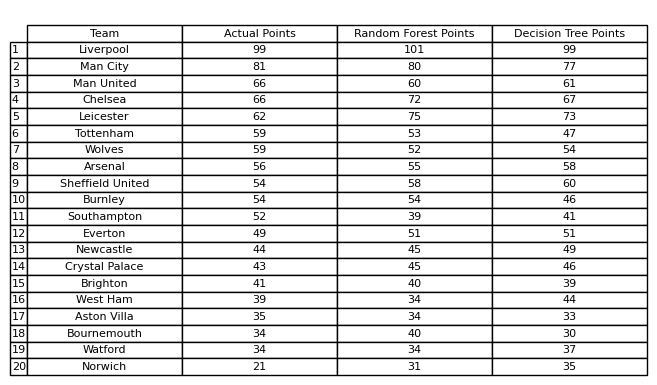

In [36]:
final = pd.merge(actual_points_1, final_table_rf, how='outer',left_on=['Team'], right_on=['Team'])
final = pd.merge(final, final_table_dt, how='outer',left_on=['Team'], right_on=['Team'])
final = final.drop(columns=['Home Points','Away Points','Actual Placement_x', 'PredictedHomePoints_x', 'PredictedAwayPoints_x','Actual Placement_y', 'PredictedHomePoints_y',
       'PredictedAwayPoints_y'])
final = final.rename(columns={'Total Points':'Actual Points','PredictedTotalPoints_x':'Random Forest Points', 'PredictedTotalPoints_y':'Decision Tree Points'})
  
    
#Increase index by 1
final.index = final.index +1

#Create figure and axis
fig = plt.figure(figsize = (8, .2))
ax = fig.add_subplot(111)

#Create table for decsisiom tree 
ax.table(cellText = final.values, rowLabels = final.index, 
         colLabels = final.columns, cellLoc='center')



#turn axes off
ax.axis('off')
plt.show()  